In [1]:
import numpy as np
import pandas as pd
#%matplotlib inline
#import matplotlib.pyplot as plt
#import IPython.display as ipd
#from IPython.display import Audio
#import librosa
#from librosa import display
#import librosa.display
from fractions import Fraction
from collections import defaultdict, Counter
from iteration_utilities import deepflatten #flatten nested lists


#import pretty_midi

#import fluidsynth
#import soundfile as sf
#import music21
from music21 import midi, note, stream, instrument, meter, key
import itertools
import random


#import pysndfx #sound processing

import nltk #for NLP
import string
import mchmm #for Markov models

#Just a helper function
def flatten_list(hierarchical_list):
    #Flatten a list of lists
    return [x for sublist in hierarchical_list for x in sublist]

# Generating Rhythms: Content

This notebook exemplifies a few modalities of rhythm generation.

1. We start by simply assembling consecutive durations in an arbitrary way.
2. Then, we fix the probabilities for transitioning from one rhythmic element to the next, building a Markov model.
3. Rather than fixing the transition probabilities ourselves, we can train a Markov model to learn the transition probabilities (e.g. from some text corpus), and then use these transition probabilities to generate new rhythms.
4. We then implement a Context Free Grammar for generating rhythms hierarchically. 
5. Finally, we overview Nancarrow's canonic techniques and reproduce the rhythm of his Study 14 for player piano.

Before engaging with the main topics, it will be useful to define some helper functions to save some time.

# Helper functions

First, here is a shortcut for **playback**, which we have already seen in week 1 notebook:

In [2]:
def play(score):
    #Shortcut to play a stream
    midi.realtime.StreamPlayer(score).play()

**Now, we define a function to create percussion sounds that we can embed in streams.**

First, let us create a note object of given duration. 

We express durations in whole-note units, so that quarter-notes have duration 1/4, eigth-notes have duration 1/8 etc. You can easily change the duration unit by assigning a new value to the UNIT variable.

Since we are dealing with rhythm, we don't really care about the pitch of the notes, so we assign a default value (C4). When calling the percussion_hit function, you can either stick to the default pitch (just omit the pitch parameter) or you can specify a new value for the pitch parameter.

In [3]:
#GLOBAL CONSTANTS
UNIT = 1 #We express duration as fractions of a whole note. Use UNIT = 1/4 to express durations as fractions of quarter-notes

def percussion_hit(duration, pitch = "C4"):
    #Create Note object for percussion hits (default pitch is C4)
    return note.Note(pitch, quarterLength = duration*(4*UNIT))

So, a percussion_hit of duration 1 (whole-note) spans 4 quarter-notes:

In [4]:
percussion_hit(1).quarterLength

4.0

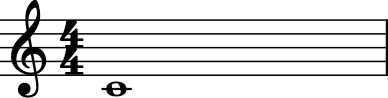

In [5]:
percussion_hit(1).show()

**Now, we create a container object (a Stream or a Measure) for our percussion_hits.**

By default, no time signature is specified, so that a single measure of unspecified capacity is generated. If you do specify a time signature when calling the create_percussion function, a stream with the given time signature is created instead.

In [6]:
def create_percussion(time_sig = None):
    #Initialize a percussion stream with Woodblock timbre
    #If time signature is None, no measure splits
    if time_sig == None:
        drumPart = stream.Measure()
    else:
        drumPart = stream.Stream()
        drumPart.timeSignature = meter.TimeSignature(time_sig)
    
    drumPart.insert(0, instrument.Woodblock()) #assign woosblock timbre
    return drumPart

**We can now embed a percussion_hit in a stream.**

To simplify the process, we define new functions that append a percussion_hit of given duration to a percussion stream:

In [7]:
def append_event(duration, original_stream, rest = False, pitch = 'C4'):
    #Returns a new_stream obtained by appending a rhythmical event or a rest of given duration to the original_stream
    new_stream = original_stream
    if rest:
        new_stream.append(note.Rest(quarterLength = duration*(4*UNIT)))
    else:
        new_stream.append(percussion_hit(duration, pitch))
    return new_stream


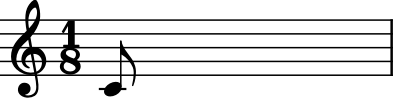

In [8]:
m = create_percussion()
append_event(1/8, m).show()

# 1. Additive rhythm generation

**We are ready to produce rhythms! Let's just chain durations by appending them to the same Stream object.**

By running the following cell with start_new set to True, you initialise an empty rhythmic stream and fill it with one note of duration new_duration. If you set start_new to False, you can keep adding new notes to the stream. Every time you append a new note, you can decide its duration by assigining a value to the variable new_duration. You can also insert rests, by changing the truth value of the is_rest variable.

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


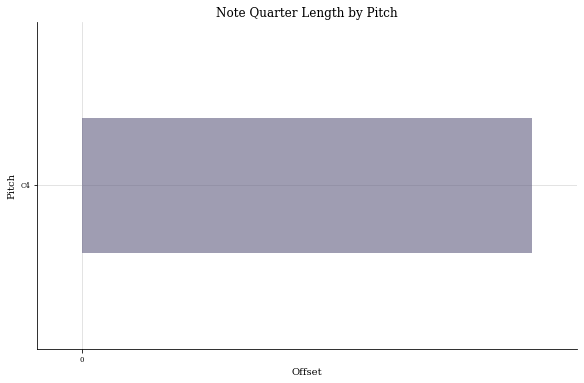

In [9]:
start_new = True

#What duration do you want to add to the rhythm?
new_duration = 13/167
is_rest = False

if start_new:
    #If start_new is true, initialise a new rhythmic stream
    initial = create_percussion()

updated = initial
updated = append_event(new_duration, updated, rest = is_rest)

    
updated.plot()
play(updated)

### Exercise: Accelerando

Use the above code to produce an accelerating rhythm by adding shorter and shorter durations starting from an arbitrary initial duration. 

## Rhythm from list of durations

**Instead of adding one percussion_hit at a time, we can specify a whole sequence of durations at once:**

In [10]:
def rhythm_from_sequence(durations, time_sig = None, pitch = 'C4', rhythm=None):
    #Generate rhythmic stream from a list of durations. Rests are indicated by specifying a duration as a string
    if rhythm is None:
        # pass an existing stream 'rhythm' to append the durations, otherwise a new one will be created
        rhythm = create_percussion(time_sig = time_sig)
    for dur in durations:
        is_rest = False
        if dur != 0:
            if isinstance(dur, str):
                #if duration is given as a string, interpret and rest and turn string into a numerical value
                is_rest = True
                dur = Fraction(dur)
            
            rhythm = append_event(dur, rhythm, rest = is_rest, pitch = pitch) 
    return rhythm


Let's play and show a sequence of arbitrary durations:

In [11]:
duration_sequence = [1/4, 1/8, 1/8, 1/4/3, 2/4/3, '1/8',  1/4]    
rhythm = rhythm_from_sequence(duration_sequence)
play(rhythm)    

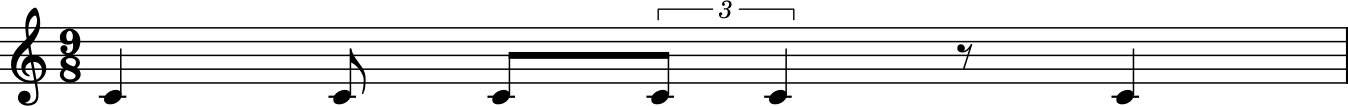

In [12]:
rhythm.show()

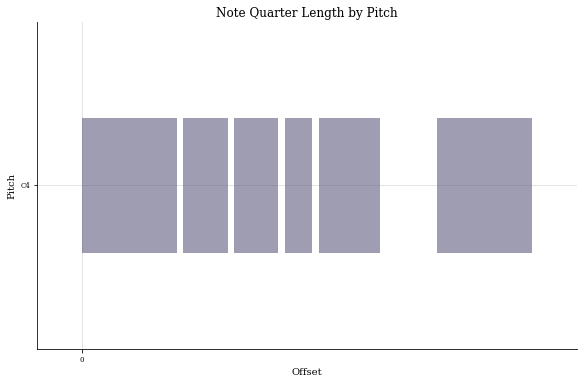

In [13]:
rhythm.plot()

### Exercise: Rhythmic transcription

Use the function `rhythm_from_sequence()` to transcribe the following rhythmic sequence:

<img src="BlueBossa.png">

Here is a little refresher of rhythmic notation that might help you convert notes into duration values:

<img src="RhythmicNotation.png">

# 2. Markov chains

Music is about *organising* sounds in time. As a consequence, we want our rhythms to be governed by some **generative principle**.

A possible generative principle is to specify the probability for any new event in a sequence given the preceding event(s). Therefore, a Markov model can be expressed as a **transition table** such as the one seen in the last lecture, slide 19:

<img src="transitions.png">

## Designing a Markov model manually

First, we decide what our **vocabulary** is going to be, the possible states of the model. We could base the model, e.g. on transitions between onset positions (as above), between durations, or between rhythmic cells.

Let's go with the latter and handcraft two rhythmic cells as lists of durations.

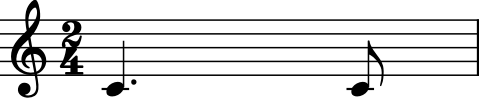

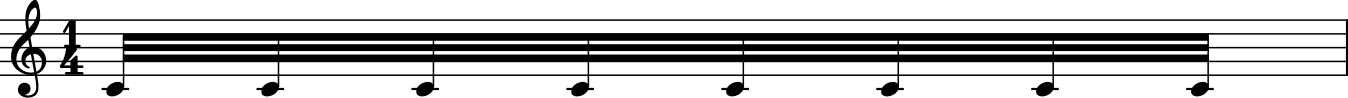

In [14]:
a = (3/8, 1/8)
b = (1/32,) * 8
states = (a, b)
rhythm_from_sequence(a).show()
rhythm_from_sequence(b).show()

For every element in our vocabulary, we need to define a transition probability to every element. We could define a function for that but since we defined the rhythmic cells as tuples, we can have it easier, as a dictionary (wouldn't work with lists as keys):

In [15]:
transitions = {
    a: [[a, b], [0.9, 0.1]],
    b: [[a, b], [0.9, 0.1]]
}

From this dictionary, we can easily access the transitions from a given a state to what is going to be the next state in the chain:

In [16]:
transitions[a]

[[(0.375, 0.125),
  (0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125)],
 [0.9, 0.1]]

All that's left to do is define

* where the Markov chain starts
* how many states we want to append to the Markov chain and pick randomly

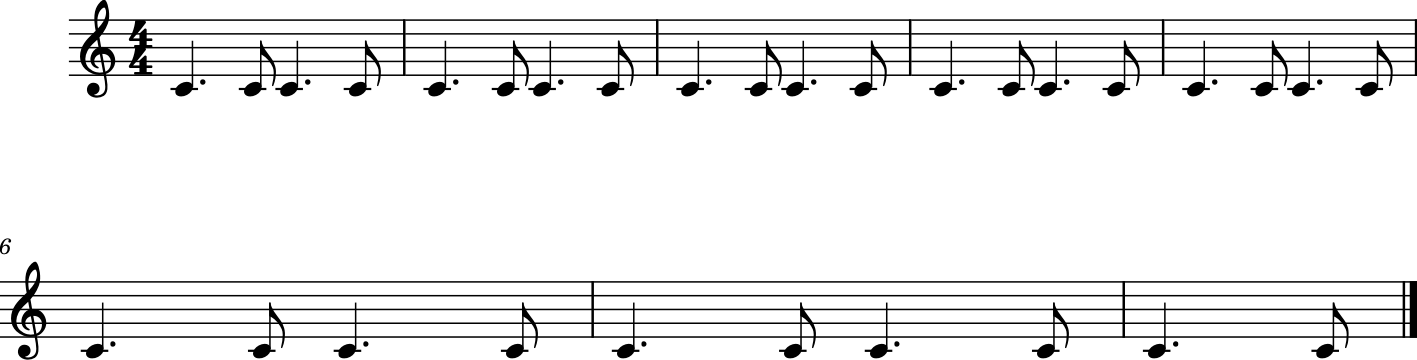

In [17]:
current_state = a
chain_length = 15

markov_rhythm = create_percussion(time_sig = '4/4')
for _ in range(chain_length):
    markov_rhythm = rhythm_from_sequence(current_state, rhythm=markov_rhythm)
    next_states, probs = transitions[current_state]
    current_state = random.choices(next_states, probs)[0]

markov_rhythm.show()

In [18]:
play(markov_rhythm)

# 3. Train Markov model

Now, instead of specifying the transition probabilities arbitrarily, we can infer them from some other stochastic process: for example, word lengths in a literary text. 

## Getting word lengths from a literary text

`NLTK`, a python library for natural language processing, provides us with the tools to do it. First, let's download a collection of famous texts, a corpus from the [Gutenberg project](https://www.gutenberg.org/):

In [19]:
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\hentsche\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

The corpus includes the following texts:

In [20]:
nltk.corpus.gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

Let's pick Carrol's *Alice in Wonderland*:

In [21]:
alice_in_wonderland = nltk.corpus.gutenberg.words('carroll-alice.txt')
print(f"The list has {len(alice_in_wonderland)} strings.")
alice_in_wonderland[:20]

The list has 34110 strings.


['[',
 'Alice',
 "'",
 's',
 'Adventures',
 'in',
 'Wonderland',
 'by',
 'Lewis',
 'Carroll',
 '1865',
 ']',
 'CHAPTER',
 'I',
 '.',
 'Down',
 'the',
 'Rabbit',
 '-',
 'Hole']

To get the actual word length, we need to remove punctuation signs and can use this predifined list:

In [22]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [23]:
filtered = list(filter(lambda word: np.product([character not in string.punctuation for character in word ]), alice_in_wonderland)) # filter out punctuation
print(f"The list now has {len(filtered)} strings.")
filtered[:20]

The list now has 27334 strings.


['Alice',
 's',
 'Adventures',
 'in',
 'Wonderland',
 'by',
 'Lewis',
 'Carroll',
 '1865',
 'CHAPTER',
 'I',
 'Down',
 'the',
 'Rabbit',
 'Hole',
 'Alice',
 'was',
 'beginning',
 'to',
 'get']

Now we map the function `len()` to all words to get a list of word lengths:

In [24]:
wl =list(map(len, filtered))
wl[:20]

[5, 1, 10, 2, 10, 2, 5, 7, 4, 7, 1, 4, 3, 6, 4, 5, 3, 9, 2, 3]

## Getting transition probablities

Now we have to get from the list of word lengths to a transition table between word lengths. For that, we create **bigrams**, that we can count, i.e. a list `[a, b, c, d]` is transformed into a list of bigrams `[(a, b), (b, c), (c, d)]`.

This can be achieved by zipping the list without the last element `[a, b, c]` together with the list without the first element `[b, c, d]`:

In [25]:
bigrams = list(zip(wl[:-1], wl[1:]))
bigrams[:20]

[(5, 1),
 (1, 10),
 (10, 2),
 (2, 10),
 (10, 2),
 (2, 5),
 (5, 7),
 (7, 4),
 (4, 7),
 (7, 1),
 (1, 4),
 (4, 3),
 (3, 6),
 (6, 4),
 (4, 5),
 (5, 3),
 (3, 9),
 (9, 2),
 (2, 3),
 (3, 4)]

This list of bigrams needs to be transformed into **relative bigram frequencies** which we then use as probabilities.

To get there, we first need the **absolute** bigram frequirencies, or bigram counts.
That is to say, we need to sort our `(x, y)` in a way that for every `x` we count how often it transitions to any `y`. For this, we can use the very useful `defaultdict` and `Counter` object (if you don't know them, read them up).

In [26]:
dd = defaultdict(Counter)
for x, y in bigrams:
    dd[x].update([y])

In [27]:
dd[1] # transition from word length 1 to any other word length (doesn't necessarily cover all possible transitions, only those occurring in the corpus)

Counter({10: 16,
         4: 448,
         5: 273,
         6: 238,
         9: 30,
         3: 274,
         2: 148,
         1: 105,
         7: 122,
         8: 39,
         12: 5,
         11: 4})

Now we can turn this into a list of lists to display this as a transition table. Remember we need to cover all possible transistions, so we can simply do it with a nested for loop going through all word lengths.

First, we need to know the maximal word length, assuming that all smaller ones occur, too:

In [28]:
max_wl = max(dd.keys())
all_wls = list(range(1, max_wl+1))
all_wls

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [29]:
transitions = []
for x in all_wls:
    row = [dd[x][y] for y in all_wls]
    transitions.append(row)
transition_table = pd.DataFrame(transitions, index=all_wls, columns=all_wls)
transition_table

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1,105,148,274,448,273,238,122,39,30,16,4,5,0,0
2,331,560,1396,935,484,265,235,87,72,29,9,7,3,0
3,392,766,1469,1759,1095,616,465,264,126,47,51,9,3,2
4,426,1113,1639,1072,591,356,303,135,80,39,19,4,4,1
5,219,649,949,611,327,230,194,85,45,21,7,2,0,1
6,101,442,525,373,216,97,96,45,41,10,4,1,1,0
7,79,397,415,282,160,74,75,41,31,9,4,4,0,0
8,20,166,208,140,85,32,42,13,7,5,4,1,0,0
9,11,99,106,97,63,26,21,9,9,3,3,0,0,0
10,8,46,38,43,20,9,10,3,3,0,1,0,0,0


This table could be interpreted as probabilities by normalizing every row:

In [30]:
transition_table.div(transition_table.sum(axis=1), axis=0)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1,0.061692,0.086957,0.160987,0.263220,0.160400,0.139835,0.071680,0.022914,0.017626,0.009401,0.002350,0.002938,0.000000,0.000000
2,0.075006,0.126898,0.316338,0.211874,0.109676,0.060050,0.053252,0.019714,0.016315,0.006571,0.002039,0.001586,0.000680,0.000000
3,0.055493,0.108437,0.207956,0.249009,0.155011,0.087203,0.065827,0.037373,0.017837,0.006653,0.007220,0.001274,0.000425,0.000283
4,0.073677,0.192494,0.283466,0.185403,0.102214,0.061570,0.052404,0.023348,0.013836,0.006745,0.003286,0.000692,0.000692,0.000173
5,0.065569,0.194311,0.284132,0.182934,0.097904,0.068862,0.058084,0.025449,0.013473,0.006287,0.002096,0.000599,0.000000,0.000299
6,0.051742,0.226434,0.268955,0.191086,0.110656,0.049693,0.049180,0.023053,0.021004,0.005123,0.002049,0.000512,0.000512,0.000000
7,0.050286,0.252705,0.264163,0.179504,0.101846,0.047104,0.047740,0.026098,0.019733,0.005729,0.002546,0.002546,0.000000,0.000000
8,0.027663,0.229599,0.287690,0.193638,0.117566,0.044260,0.058091,0.017981,0.009682,0.006916,0.005533,0.001383,0.000000,0.000000
9,0.024609,0.221477,0.237136,0.217002,0.140940,0.058166,0.046980,0.020134,0.020134,0.006711,0.006711,0.000000,0.000000,0.000000
10,0.044199,0.254144,0.209945,0.237569,0.110497,0.049724,0.055249,0.016575,0.016575,0.000000,0.005525,0.000000,0.000000,0.000000


## Taking a shortcut

The module `mchmm` provides a quicker way to get to get to the transition counts (="train the model"):

In [31]:
#Train Markov model on the sequence of word lengths
ALICE_markov = mchmm.MarkovChain().from_data(wl)

We can show the matrix of obserbed transition counts from a word of length x to a word of length y as a `pandas` DataFrame:

In [32]:
#Showing the transition (frequency) matrix
pd.DataFrame(ALICE_markov.observed_matrix, index = ALICE_markov.states, columns = ALICE_markov.states, dtype = int)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1,105,148,274,448,273,238,122,39,30,16,4,5,0,0
2,331,560,1396,935,484,265,235,87,72,29,9,7,3,0
3,392,766,1469,1759,1095,616,465,264,126,47,51,9,3,2
4,426,1113,1639,1072,591,356,303,135,80,39,19,4,4,1
5,219,649,949,611,327,230,194,85,45,21,7,2,0,1
6,101,442,525,373,216,97,96,45,41,10,4,1,1,0
7,79,397,415,282,160,74,75,41,31,9,4,4,0,0
8,20,166,208,140,85,32,42,13,7,5,4,1,0,0
9,11,99,106,97,63,26,21,9,9,3,3,0,0,0
10,8,46,38,43,20,9,10,3,3,0,1,0,0,0


Now, we can generate a new sequence of integers (word lengths) with the markov model trained on Carrol's text. The `simulate` method of a `mchmm.MarkovChain()` object returns a list of *states* (i.e., actual word lengths) and the list of their *ID*s (i.e., the ordinal position of each state among the possible wordlengths that have been found in Carrol's text). 

In [33]:
#Simulate sequence of durations from ALICE_markov
chain_length = 12 #number of events to generate

#Markovian generation, starting with word length 3 (arbitrary).
ids, states = ALICE_markov.simulate(chain_length, start=3, seed=np.random.randint(0, chain_length, chain_length))

We can now play the resulting sequence. First, we need to decide a scaling factor to turn integers into durations (here, we opt to equate a letter to a sixteenth-note).

In [34]:
play(rhythm_from_sequence(states*1/16)) #With scaling factor 1/16

# 4. Hierarchical generation of rhythm

In a Markov model, each rhythmic event depends on the preceding one(s). A different approach to modelling rhythm is to interpret rhythmic events as recursive elaborations of a latent rhythmic structure. The following example of hierarchical rhythm generation is based on the grammar from Rohrmeier (2020) https://program.ismir2020.net/poster_4-20.html.

## Rhythmic objects

First, in this formalism, a rhythmic category is a 3-ple of parameters defining a time-span: the upbeat, the body and the tail. The body represents the "ideal" duration of the timespan, if no extensions or timestealing happen. The upbeat encodes the addition (if positive) or subtraction (if negative) of a portion at the beginning of the timespan. Similarly, the coda encodes the addition (if positive) or subtraction (if negative) of a portion at the end of the timespan. As a consequence, the overall duration of a timespan (a, b, c) is a+b+c. 

Each rhythmic category can generate other rhythmic categories by means of the application of a rule.

We define a rhythmic category as a `class`. Among the methods of this class we define the rule applications. 

In [35]:
class rhythmic_category:
    def __init__(self, upbeat, body, tail):
        #Parameters
        self.upbeat = upbeat
        self.body = body
        self.tail = tail
        self.parameters = (upbeat, body, tail)
       
    def showScore(self):
        #A helper function to display the rhythmic category. Shows a positive upbeat separately from the body+tail
        sequence = [self.upbeat, self.body + self.tail]
        if self.upbeat < 0:
            sequence[0] = 0
            sequence[1] += self.upbeat
            
        return rhythm_from_sequence(sequence).show()
        
        
    
        
    ####    
    #Rule applications
    ####
    
    def split(self, ratio = 1/2, right_child_upbeat = 0):
        #SPLIT operation on parent metrical category, based on ratio = left_child_body/parent.body. 
        #An upbeat for the right child can be specified.
        left_child_body = self.body*ratio
        right_child_body = self.body-left_child_body
    
        left_child_cat = rhythmic_category(self.upbeat, left_child_body, - right_child_upbeat)
        right_child_cat = rhythmic_category(right_child_upbeat, right_child_body, self.tail)
    
        return list(deepflatten([left_child_cat, right_child_cat]))
    
    def prepare(self):
        #UPBEAT rule: separates upbeat from body
        if self.upbeat > 0:
            left_child_cat = rhythmic_category(0, self.upbeat, 0)
            right_child_cat = rhythmic_category(0, self.body, self.tail)
    
            return list(deepflatten([left_child_cat,  right_child_cat]))
        else:
            return [self]
        
    def e_shift(self):
        #ANTICIPATE rule: shifts body to the left
        return [rhythmic_category(0, self.body, self.upbeat+self.tail)]
    
    def l_shift(self):
        #DELAY rule: shifts body to the right
        return [rhythmic_category(self.upbeat + self.tail, self.body, 0)]
    
    ####
    #Helpers to derive terminal durations at the end of a derivation
    ####
    
    def timesteal(self):
        #TIMESTEALING. If a category is left with negative upbeat or tail, subtract it from the body
        new_upbeat = self.upbeat
        new_tail = self.tail
        timestolen_body = self.body
        if self.upbeat < 0:
            new_upbeat = 0
            timestolen_body += self.upbeat
        if self.tail < 0:
            new_tail = 0
            timestolen_body += self.tail
        return [rhythmic_category(new_upbeat, timestolen_body, new_tail)]
    
    def attach_tail(self):
        #Attach tail to body, to be used if tail > 0
        return [rhythmic_category(self.upbeat, self.body+self.tail, 0)]

    
    def get_terminals(self):
    #Recursively get terminal durations from metrical categories.
    #ARBITRARY CONVENTIONS TO TERMINATE DERIVATION: If there is negative head or tail, interpret as timestealing. If there is positive head, interpret as preparation. If there is positive tail, attch it to the body.
    
        if (self.upbeat == 0) and (self.tail == 0):
            return [self.body]
        elif (self.upbeat < 0) | (self.tail < 0):
            return  list(deepflatten([x.get_terminals() for x in self.timesteal()]))
        elif self.tail > 0:
            return  list(deepflatten([x.get_terminals() for x in self.attach_tail()]))
        elif self.upbeat > 0:
            return list(deepflatten([x.get_terminals() for x in self.prepare()]))
    
        
        

For example, here is a rhythmic category:

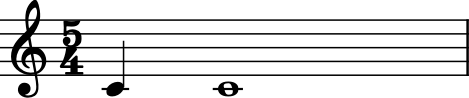

In [36]:
example_category = rhythmic_category(1/4, 1, 0)
example_category.showScore()

Rules can be applied to have this "parent" category generate other categories as its own "children".

**Split**. This rule splits a rhythmic category into two "children" by dividing the body into two parts. The left child inherits the upbeat of the parent category, while the right child inherits the coda of the parent category. Finally, the right child might "steal" a portion from the left child (if the right child has a positive upbeat), or vice-versa (if the right child has a negative upbeat). The split rule comes with two parameters. First, the split ratio (which is often 1/2, representing an equal split). The second parameter is optional, and specifies the upbeat of the right child (default is 0).

In [37]:
splitted_example = example_category.split(1/2)
splitted_example

In [38]:
[child.parameters for child in splitted_example]

[(0.25, 0.5, 0), (0, 0.5, 0)]

Note that this is an equal split where the children do not steal time from each other. Here we have a different split, where the right child has an upbeat, hence stealing time from the left child:

In [39]:
splitted_example_with_upbeat = example_category.split(1/2, 1/16)
[child.parameters for child in splitted_example_with_upbeat]

[(0.25, 0.5, -0.0625), (0.0625, 0.5, 0)]

**Prepare**. This rule separates the upbeat (if it is positive) from the body, creating two distinct rhytmic categories: one inherits the parent's upbeat as its own body, the other inherits the parent's body and tail (but has not upbeat).

In [40]:
[child.parameters for child in example_category.prepare()]

[(0, 0.25, 0), (0, 1, 0)]

**Anticipate and Delay**: these two rules are unary rules, i.e. the parent is simply transformed into one different category. In the anticipation (or e-shift) rule, the upbeat is absorbed into the body, so that the body of the timespan is shifted to the left. The delay (or l-shift) rule does the opposite.

Here is, for example, an application of the anticipation rule. Since this is a unary rule, only one child is generated:

In [41]:
[child.parameters for child in example_category.e_shift()]

[(0, 1, 0.25)]

## Generation

Starting with a "root" rhythmic category, we can apply these rules recursively to generate a rhythm within the timespan of the root.

Let us first define some useful functions.

The `rule` function just specifies a rule to be applied, with its parameters.

In [42]:
def rule(rule_type, p1 = None, p2 = None):
    #Returns dictionary specifying a rule with its parameters
    
    rule_def = {'type': rule_type}
    
    if p1 != None:
        rule_def['p1'] = p1
    if p2 != None:
        rule_def['p2'] = p2
    
    return rule_def
    

The `generate_hierarchical_rhythm` function is the most important one. In order to generate a rhythm, we need a root category and a recipe that specifies what rules are to be applied (and in what order). Given a recipe and a root category, this function reads the recipe and applies the required rules recursively to the children, grand-children, grand-grand-children etc. of the root category.  

In [43]:
def generate_hierarchical_rhythm(tree, starting_symbol, preterminal_string = []):
    #Recursively generate rhythm from a hierarchy of rule applications
    
    if len(tree) == 0:
        return preterminal_string + [starting_symbol]
    else:
        rule = tree[0]
        if rule['type'] == 'split':
            children = starting_symbol.split(ratio = rule['p1'], right_child_upbeat = rule['p2'])
        elif rule['type'] == 'prepare':
            children = starting_symbol.prepare()
        elif rule['type'] == 'anticipate':
            children = starting_symbol.e_shift()
        elif rule['type'] == 'delay':
            children = starting_symbol.l_shift()
            
               
        for child_n in range(len(children)):
            preterminal_string = generate_hierarchical_rhythm(tree[child_n+1], children[child_n], preterminal_string = preterminal_string)
                
    
        return preterminal_string
    

The last few function just help to turn the output of `generate_hierarchical_rhythm` into a list of durations, and to turn this list of durations into a music21 stream.

In [44]:
def get_terminal_durations(rhythmic_categories):
    #Turns list of pre-terminal categories in list of terminal durations
    return list(deepflatten([x.get_terminals() for x in rhythmic_categories]))


def hierarchical_rhythm(tree, starting_symbol):
    #generate list of durations hierarchically
    return get_terminal_durations(generate_hierarchical_rhythm(tree, starting_symbol))

def rhythm(tree, starting_symbol, time_sig = None):
    #Show score  
    return rhythm_from_sequence(hierarchical_rhythm(tree, starting_symbol), time_sig = time_sig)
    

Here, as an example, we generate the initial rhythm from the Jazz standard "Blue Bossa" (Rohrmeier 2020). 

The rhythm lasts 4 bars (in 4/4 meter) plus a 1/4 upbeat, so that the root category is:

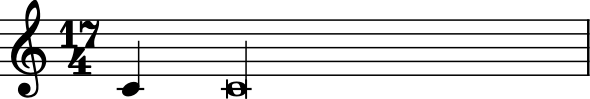

In [45]:
root = rhythmic_category(1/4, 4, 0)
root.showScore()

<img src="bb01.png">
The recipe to generate a rhythm can be represented in the form of a derivation tree. Each node of the tree is occupied by a rhythmic category, and the branches originating at a node lead to the children of that node under some rule application. A full derivation tree for Blue Bossa is the following: 

<img src="HierarchicalRhythm.png">

Let us start from the top of the tree, where we find the root category. The first branching is a split rule (the body is split in half), leading to two children nodes. We can represent a node of the tree as a list, containing the rule applied at that node (if any), as well as its children nodes. In the case of the topmost node in the above tree, the rule is a split with ratio 1/2 and right-child's head 1/4. Since we are not applying any rule to the two children nodes (yet), they are represented as empty lists. 

In [46]:
tree = [rule('split',1/2, 1/4), #root
            [], #left child of the root
            []  #right child of the root
       ]

The function `rhythm` takes a tree and a root as arguments and returns a music21 stream with the resulting rhythm. In order to do that, it calls the recursive function `generate_hierarchical_rhythm` that reads the tree and applies the rule applications, starting with the root category.

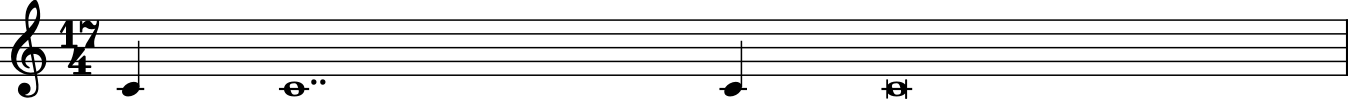

In [47]:
generated_rhythm = rhythm(tree, root)
generated_rhythm.show()

<img src="bb02.png">
Let's look now at the left child of the root node. Here, another split rule is applied, resulting in two children with equal body (split factor 1/2) and a 1/8 upbeat for the right child. 

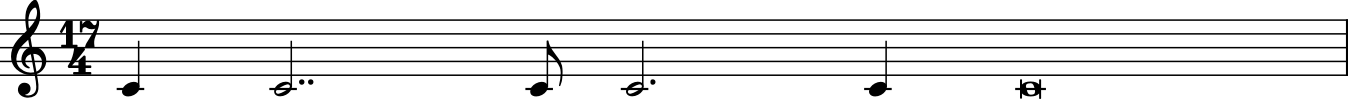

In [48]:
tree = [rule('split',1/2, 1/4), #root
            [rule('split', 1/2, 1/8), #left child of the root
                 [], #left child of the left child of the root
                 []  #right child of the left child of the root
            ],
            [] #right child of the root
       ]
generated_rhythm = rhythm(tree, root)
generated_rhythm.show()
play(generated_rhythm)

<img src="bb03.png">
The left child of the left child of the root also undergoes a split operation...

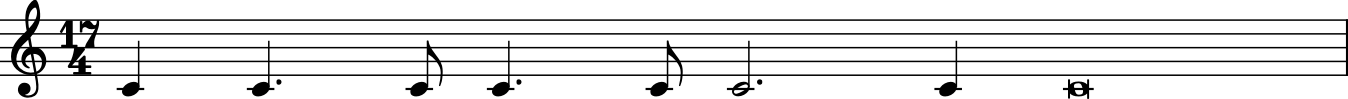

In [49]:
tree = [rule('split',1/2, 1/4), #root
            [rule('split', 1/2, 1/8), #left child of the root
                 [rule('split', 1/2, 1/8), #left child of the left child of the root
                      [], #left child of the left child of the left child of the root
                      []  #right child of the left child of the left child of the root
                 ],
                 [] #right child of the left child of the root
            ],
            [] #right child of the root
       ]
generated_rhythm = rhythm(tree, root)
generated_rhythm.show()
play(generated_rhythm)

<img src="bb04.png">
... while its own left child (i.e., of the left child of the left child of the root) undergoes a preparation rule...

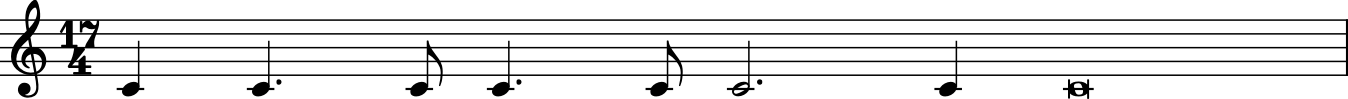

In [50]:
tree = [rule('split',1/2, 1/4), #root
            [rule('split', 1/2, 1/8), #left child of the root
                 [rule('split', 1/2, 1/8), #left child of the left child of the root
                      [rule('prepare'), #left child of the left child of the left child of the root
                           [], #left child of the left child of the left child of the left child of the root
                           []  #right child of the left child of the left child of the left child of the root
                      ],
                      [] #right child of the left child of the left child of the root
                 ],
                 [] #right child of the left child of the root
            ],
            [] #right child of the root
       ]
generated_rhythm = rhythm(tree, root)
generated_rhythm.show()
play(generated_rhythm)

... similarly to the right child of the left child of the left child of the root:

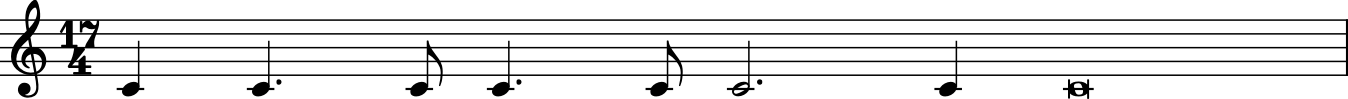

In [51]:
tree = [rule('split',1/2, 1/4),
            [rule('split', 1/2, 1/8),
                 [rule('split', 1/2, 1/8),
                      [rule('prepare'),
                           [],
                           []
                      ],
                      [rule('prepare'),
                           [],
                           []
                      ]
                 ],
                 []
            ],
            []
       ]
generated_rhythm = rhythm(tree, root)
generated_rhythm.show()
play(generated_rhythm)

The right child of this preparation rule is further elaborated with a split, whose right child is then anticipated:

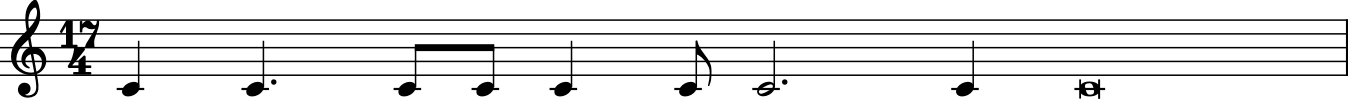

In [52]:
tree = [rule('split',1/2, 1/4),
            [rule('split', 1/2, 1/8),
                 [rule('split', 1/2, 1/8),
                      [rule('prepare'),
                           [],
                           []
                      ],
                      [rule('prepare'),
                           [],
                           [rule('split', 1/2, 1/8),
                                [],
                                [rule('anticipate'),
                                     []
                                ]
                           ]
                      ]
                 ],
                 []
            ],
            []
       ]
generated_rhythm = rhythm(tree, root)
generated_rhythm.show()
play(generated_rhythm)

<img src="bb06.png">
Fast-forward to the whole tree:

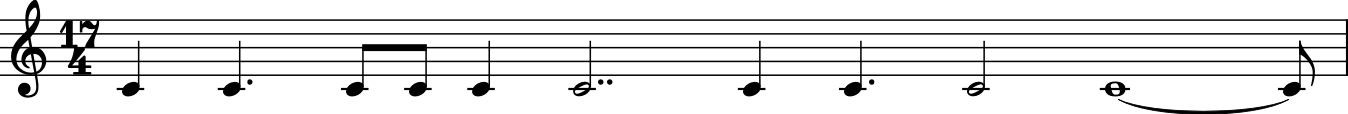

In [53]:
complete_tree = [rule('split',1/2, 1/4),
            [rule('split', 1/2, 1/8),
                 [rule('split', 1/2, 1/8),
                      [rule('prepare'),
                           [],
                           []
                      ],
                      [rule('prepare'),
                           [],
                           [rule('split', 1/2, 1/8),
                                [],
                                [rule('anticipate'),
                                     []
                                ]
                           ]
                      ]
                 ],
                 [rule('anticipate'),
                     []
                 ]
            ],
            [rule('split', 1/2, 1/8),
                 [rule('split', 1/2, 1/8),
                      [rule('prepare'),
                           [],
                           []
                      ],
                      [rule('anticipate'),
                           []
                      ]
                 ],
                 [rule('anticipate'),
                      []
                 ]
            ]
       ]

generated_rhythm_complete = rhythm(complete_tree, root)
generated_rhythm_complete.show()
play(generated_rhythm_complete)

<img src="bb07.png">
Now that we have the rhythm, we can add the melody:

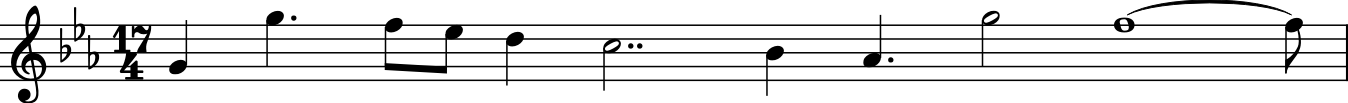

In [54]:
melody_pitches = ['G4', 'G5', 'F5', 'Eb5', 'D5', 'C5', 'Bb4', 'Ab4', 'G5', 'F5']
melody_durations = hierarchical_rhythm(complete_tree, root)
melody = stream.Measure()
melody.append(key.KeySignature(-3))
for i in range(len(melody_pitches)):
    melody.append(note.Note(pitch = melody_pitches[i], quarterLength = 4*melody_durations[i]))

melody.show()

Note that we are representing the rhythm with no information about the meter: we are just juxtaposing durations that sum up to 17 quarter-notes. Nevertheless, you can probably perceive the metrical grid when listening to the rhythm alone. 

We can make the metrical grid explicit by having an isochronous beat played alongside the melody:

In [55]:
s = stream.Score()
s.append(stream.Part())
s.append(stream.Part())

s[0].append(melody)

metrical_grid = ['1/4'] + [2/4]*8
s[1].append(rhythm_from_sequence(metrical_grid))

play(s)

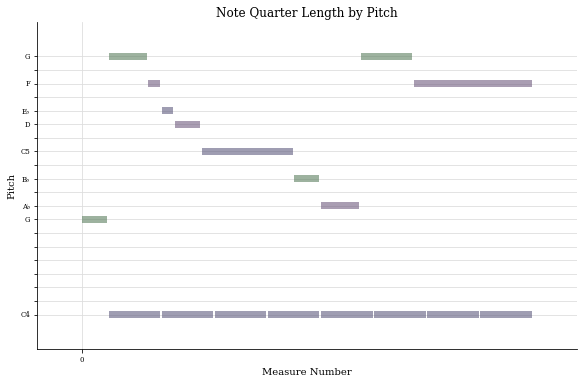

In [56]:
s.plot()

# 5. Nancarrow: Canonic techniques

Thomas, M. E. (2000). Nancarrow’s Canons: Projections of Temporal and Formal Structures. Perspectives of New Music, 38(2), 106–133. https://doi.org/10.2307/833661


Canons are based on imitations between two (or more) voices: one that proposes a subject to imitate (*dux*), and one that follows with an imitation (*comes*). The imitation may be varied in various ways. 

One canonic technique for rhythm is to have the imitation speeding up (or slowing down). This will result in the *dux* and the *comes* to be out of phase, axcept at one point. The point of synchrony can be set at the beginning (so that the two voices seem to *diverge*), at the end (so that the two voices seem to *converge*), or in the middle (so that the two voices seem to converge and then diverge). Here is an example with an isochronous rhythm.

In [57]:
####
#TEMPO CHANGE
####

#Set-up stream with two parts
canon = stream.Measure()
canon.insert(0, stream.Part())
canon.insert(0, stream.Part())

#number of rhythmic events
length = 16

#each note in the 'comes' lasts perc less than the preceding
perc = .02

#where in sync?
synchrony = 7 #synchrony = 1: divergent; synchrony = length: convergent; 1<synchrony<length: convergent-divergent

#set start of the 'comes' in order to have synchrony at the desired place
displace = sum([(1-perc)**k for k in range(synchrony-1)])-(synchrony-1)

for i in range(length):
    canon[0].insert(i, note.Note(64, quarterLength=1)) #dux
    canon[1].insert(-displace+sum([(1-perc)**k for k in range(i)]), note.Note(65, quarterLength=(1-perc)**i)) #comes (accelerating)
    
play(canon)

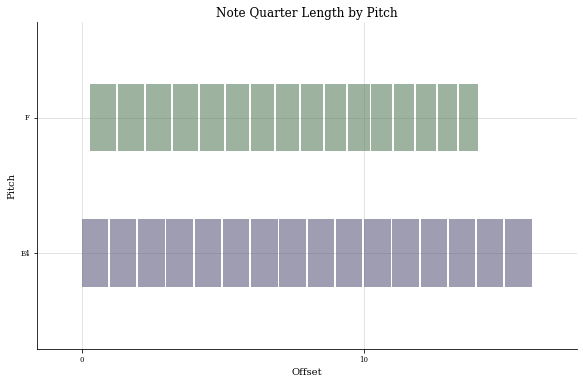

In [58]:
canon.plot()

Another technique is to have the *dux* and the *comes* playing at different tempos, in a constant ratio.  

In [59]:
####
#CONSTANT RATIO
####

#Setup stream with two parts
canon = stream.Measure()
canon.insert(0, stream.Part())
canon.insert(0, stream.Part())

#number of rhythmic events
length = 16

#tempo ratio
ratio = 4/5

#where in sync?
synchrony = length #synchrony = 1: divergent; synchrony = length: convergent; 1<synchrony<length: convergent-divergent

#set start of the 'comes' in order to have synchrony at the desired place
displace = ratio*(synchrony -1) - (synchrony-1)

for i in range(length):
    canon[0].insert(i, note.Note(64, quarterLength=1)) #dux
    canon[1].insert(-displace+ratio*i, note.Note(65, quarterLength=ratio)) #comes

play(canon)

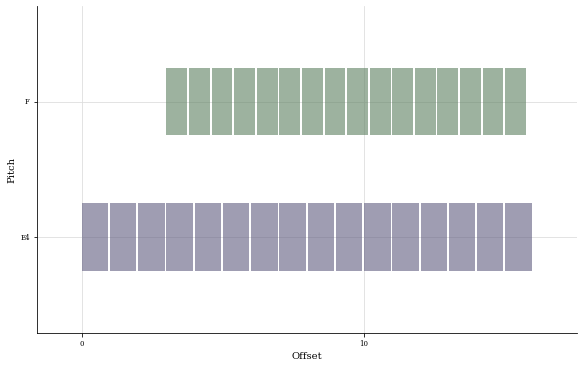

In [60]:
canon.plot(title = '')

##### Exercise: Rhythmic canon

In the preceding examples, the rhythm is just a constant beat. Enrich one of the examples (either the accelerating canon or the constant-ratio canon) by replacing the uniform rhythm with a more interesting one. Generate a 4-bar rhythm (16 quarter-note beats) with either a markovian or a hierarchical approach, and feed the new duration values into the *dux* and the *comes* of a canon.     

## Study 14

We replicate here one of Nancarrow's canonic studies for player piano. Specifically, we reconstruct the rhythmic template of Study 14. We do not attempt to replicate the pitches of the notes comprising the piece, because those are not part of the algorithmic conception of the piece: they are chosen "by hand" by the composer. 

Study 14 is a canon with two voices, a "slow" voice (the dux) and a "fast" voice (the comes), with a tempo ratio of 4/5. The two voices play the same rhythm (at different tempos). The rhythm in each voice is obtained by the superposition of 4 rhythmic streams. Each rhythmic stram is based on a different base duration n (with n = 3, 4, 5, or 6 eigth-notes), and cycles through the duration values n, n+1, n+2, n+1 etc.

The arrangement of the two voices is a converging-diverging canon, with a point of convergence at the middle of the piece. 

In [61]:
base_durations = [3,4,5,6]
unit = 0.5 #duration unit in quarter lengths
ratio = 4/5 #an eigth note of the faster voice lasts 4/5 of an eigth note of the slower voice

length = 336 #overall length in eigth-notes
displacement = (1-ratio)*(length/2) # displacement of the 'comes' to get simultaneity at midpoint

def rhythmic_series(n):
    #Series of IOIs for each base duration n
    return [n, n+1, n+2, n+1]

#set-up stream with two parts
study14 = stream.Measure()
study14.insert(0, stream.Part())
study14.insert(0, stream.Part())

for rhythmic_stream in base_durations: #for each base duration
    
    cumulative = [] #keep track of the progress in the piece 
    series = rhythmic_series(rhythmic_stream) #generate the series of IOIs from the base duration
    
    while sum(cumulative)<=length: #iterate until IOIs exceed the piece length 
        
        IOI = series[len(cumulative)%4] #current IOI (in the 4-cycle) 
        study14[0].insert(sum(cumulative)*unit, note.Note(57+rhythmic_stream, quarterLength=unit)) #dux: each stream is played on a different note starting from C4 (midi = 60)
        study14[1].insert((displacement+sum(cumulative)*ratio)*unit, note.Note(57+12+rhythmic_stream, quarterLength=unit*ratio)) #comes: each stream is played on a different note starting from C5 (midi = 72)
        
        #update cumulative for the given stream
        cumulative += [IOI]

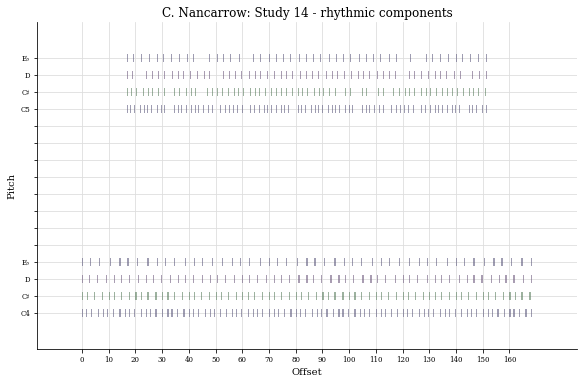

In [62]:
study14.plot(title = 'C. Nancarrow: Study 14 - rhythmic components')

In [63]:
study14.show('midi')